# Visualizing the evolution of mobile deployments in Metropolitan France 

*Charles Laverdure - 26 July 2023*

## Introduction 


## Librairies 

In [1]:
%reset
import pandas as pd 
import numpy as np
import geopandas as gpd
import glob
import os
# import geodatasets
import contextily as cx
from PIL import Image, ImageDraw

## Variables 

In [2]:
df_aggregated = pd.read_csv('data/anfr/20230720150852_observatoire_2g_3g_4g.csv', sep=';')
display(df_aggregated.head(2))

,id,adm_lb_nom,sup_id,emr_lb_systeme,emr_dt,sta_nm_dpt,code_insee,generation,date_maj,sta_nm_anfr,...,tpo_id,adr_lb_lieu,adr_lb_add1,adr_lb_add2,adr_lb_add3,adr_nm_cp,com_cd_insee,coordonnees,coord,statut
0,1,SFR,513700,LTE 1800,2016-12-20,031,31118,4G,2023-07-19,0312700486,...,65.0,LES HEBRAILS,RTE DE BOULOC,NaN,NaN,31620,31118,"43.793333333333, 1.375555555556",43°47'36''N 1°22'32''E,En service
1,2,SFR,513700,GSM 900,2015-12-09,031,31118,2G,2023-07-19,0312700486,...,65.0,LES HEBRAILS,RTE DE BOULOC,NaN,NaN,31620,31118,"43.793333333333, 1.375555555556",43°47'36''N 1°22'32''E,En service


## Code 

In [3]:
df_major_ops = df_aggregated[df_aggregated['adm_lb_nom'].isin(['ORANGE', 'SFR', 'FREE MOBILE', 'BOUYGUES TELECOM'])]
df_major_ops = df_major_ops[df_major_ops['statut'] == 'En service']
df_major_ops = df_major_ops.drop(['id', 'sta_nm_dpt', 'date_maj', 'tpo_id', 'adr_lb_lieu', 'adr_lb_add1', 'adr_lb_add2', 'adr_lb_add3', 'adr_nm_cp', 'com_cd_insee', 'coord', 'statut'], axis = 1)
# discard rows where value of code_insee starts with 97
df_major_ops = df_major_ops[~df_major_ops['code_insee'].str.startswith('97')]
# transform coordonnees column into two columns (latitude and longitude)
df_major_ops[['latitude', 'longitude']] = df_major_ops['coordonnees'].str.split(',', expand=True)
df_major_ops = df_major_ops.drop(['coordonnees'], axis = 1)
display(df_major_ops.head(2))
display(df_major_ops.shape)

df_major_ops['emr_dt'] = pd.to_datetime(df_major_ops['emr_dt'], format='%Y-%m-%d')
# display(df_major_ops.info())

,adm_lb_nom,sup_id,emr_lb_systeme,emr_dt,code_insee,generation,sta_nm_anfr,nat_id,sup_nm_haut,latitude,longitude
0,SFR,513700,LTE 1800,2016-12-20,31118,4G,0312700486,23,46.5,43.793333333333,1.375555555556
1,SFR,513700,GSM 900,2015-12-09,31118,2G,0312700486,23,46.5,43.793333333333,1.375555555556


(501446, 11)

In [4]:
df_grouped = df_major_ops.groupby('sta_nm_anfr').agg({'sup_id': 'first', 'adm_lb_nom' : 'first', 'emr_lb_systeme': lambda x: set(list(x)), 'emr_dt': lambda x: min(x), 'code_insee': 'first', 'generation' : lambda x: set(list(x)), 'nat_id': 'first', 'sup_nm_haut': 'first', 'latitude': 'first', 'longitude': 'first'})
display(df_grouped.head(2))
display(df_grouped.shape)

,sup_id,adm_lb_nom,emr_lb_systeme,emr_dt,code_insee,generation,nat_id,sup_nm_haut,latitude,longitude
sta_nm_anfr,,,,,,,,,,
0010990001,560273,FREE MOBILE,"{UMTS 900, LTE 1800, LTE 700, LTE 2100, LTE 2600}",2011-08-26,01344,"{4G, 3G}",33,89.0,46.206944444444,5.206666666667
0010990002,891727,FREE MOBILE,"{UMTS 900, LTE 1800, LTE 700, LTE 2100, LTE 2600}",2012-12-12,01053,"{4G, 3G}",38,27.5,46.202222222222,5.243055555556


(106232, 10)

In [5]:
# order the df by date
df_grouped = df_grouped.sort_values(by=['emr_dt'])

# divide the dataframe into 4 dataframes, one for each operator
df_orange = df_grouped[df_grouped['adm_lb_nom'] == 'ORANGE']
df_sfr = df_grouped[df_grouped['adm_lb_nom'] == 'SFR']
df_free = df_grouped[df_grouped['adm_lb_nom'] == 'FREE MOBILE']
df_bouygues = df_grouped[df_grouped['adm_lb_nom'] == 'BOUYGUES TELECOM']

In [6]:
display(len(df_orange)) 
display(len(df_sfr))
display(len(df_free))
display(len(df_bouygues))

29799

25655

24967

25811

In [7]:
# plotting 
france = gpd.read_file('data/france.shp')

# transform the df into a geodataframe
gdf_orange = gpd.GeoDataFrame(df_orange, geometry=gpd.points_from_xy(df_orange.longitude, df_orange.latitude), crs="EPSG:4326")
# df_wm_orange = gdf_orange.to_crs(epsg=2154)
gdf_sfr = gpd.GeoDataFrame(df_sfr, geometry=gpd.points_from_xy(df_sfr.longitude, df_sfr.latitude), crs="EPSG:4326")
# df_wm_sfr = gdf_sfr.to_crs(epsg=2154)
gdf_free = gpd.GeoDataFrame(df_free, geometry=gpd.points_from_xy(df_free.longitude, df_free.latitude), crs="EPSG:4326")
# df_wm_free = gdf_free.to_crs(epsg=2154)
gdf_bouygues = gpd.GeoDataFrame(df_bouygues, geometry=gpd.points_from_xy(df_bouygues.longitude, df_bouygues.latitude), crs="EPSG:4326")
# df_wm_bouygues = gdf_bouygues.to_crs(epsg=2154)

list_of_dfs = [gdf_orange, gdf_sfr, gdf_free, gdf_bouygues]


In [8]:
def plot(date, df, operateur):

    # color dictionary
    color_dict = {'Orange': 'orange', 'SFR': 'red', 'Free': 'grey', 'Bouygues Telecom': 'blue'}
    base = france.plot(figsize=(14, 12), edgecolor="k", color= 'none', linewidth=0.5)
    df.plot(ax = base, alpha=1, edgecolor="k", color= color_dict[operateur], markersize=3, linewidth=0.1)
    cx.add_basemap(base, source = cx.providers.CartoDB.Positron, crs="EPSG:4326")
    base.set_axis_off()
    title = operateur + ' - ' + str(date)[:4]
    base.set_title(title, fontsize=20)
    base.get_figure().savefig('images/' + operateur + '/' + operateur + str(date)[:10] + '.png', bbox_inches='tight', pad_inches=0, dpi=300)
    base.get_figure().clf()
    
    

In [9]:
def make_gif(frame_folder, operateur):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save(operateur + ".gif", format="GIF", append_images=frames,
               save_all=True, duration=200, loop=4)
    

Free


c:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 20).
  warnings.warn(msg)


KeyboardInterrupt: 

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

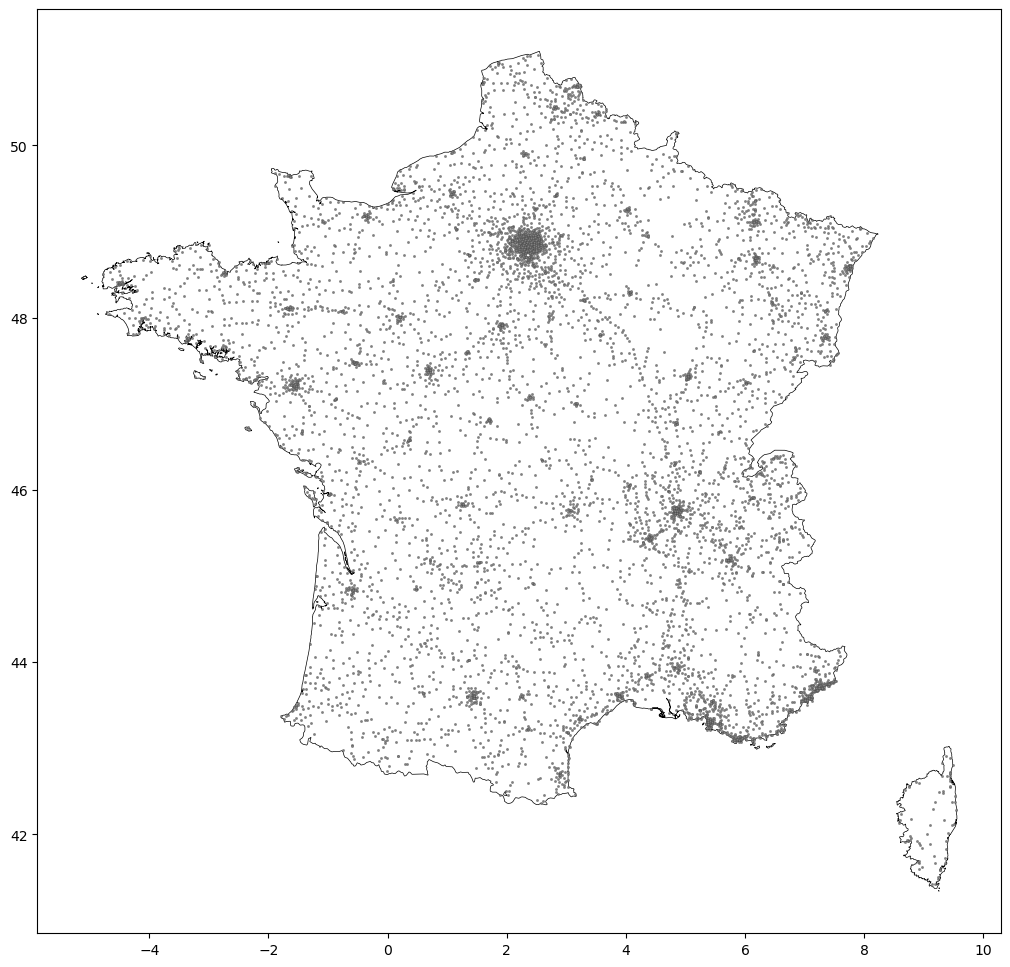

In [10]:
# create a loop that goes through the years of gdf_orange and plots the corresponding map
liste_names = ['Orange', 'SFR', 'Free', 'Bouygues Telecom']
liste_names = ['Free']
o = 0
for df in list_of_dfs:
    operateur = liste_names[o]
    print(operateur)
    for date in df['emr_dt'].dt.year.unique():
        date = pd.to_datetime(str(date), format='%Y')
        gdf_before = df[df['emr_dt'] < date]
        image = plot(date, gdf_before, operateur)
    
    make_gif('images/' + operateur, operateur)
    # clear content of the folder
    files = glob.glob('images/' + operateur + '/*')
    for f in files:
        os.remove(f)
    o += 1